In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyproj import Transformer

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.svm import SVC

In [31]:
#기본 정보
coord_std=pd.read_excel('./기본정보_위경도.xlsx')

#숙박 유형
pension=pd.read_excel("./숙박유형_관광펜션업.xlsx")
camping=pd.read_excel("./숙박유형_일반야영장업.xlsx")
hanok=pd.read_excel("./숙박유형_한옥체험업.xlsx")
resort=pd.read_excel("./숙박유형_호텔리조트.xlsx") 

#비대면
alien1=pd.read_csv('./비대면_외지인방문자수_1.csv',encoding='cp949')
alien2=pd.read_csv('./비대면_외지인방문자수_2.csv',encoding='cp949')
resider1=pd.read_csv('./비대면_현지인방문자수_1.csv',encoding='cp949')
resider2=pd.read_csv('./비대면_현지인방문자수_2.csv',encoding='cp949')

#식음및부대시설
meal=pd.read_csv('./부대시설_음식점.csv',encoding='cp949')
cafe=pd.read_csv('./부대시설_휴게음식점.csv',encoding='utf-8')

#콘텐츠
contents1=pd.read_csv('./콘텐츠_관광지_검색순위_상.csv',encoding='cp949')
contents2=pd.read_csv('./콘텐츠_관광지_검색순위_하.csv',encoding='cp949')

In [32]:
#xy좌표를 위경도로 변환
transformer = Transformer.from_crs(2097, 4326)

def convert_coordinates(lon, lat):
    new_lat, new_lon = transformer.transform(lat, lon) 
    return new_lon, new_lat  

숙박유형

In [33]:
def accomm_preprocess(accomm):
    accomm.drop(accomm[(accomm['영업상태구분코드']!=1)].index,inplace=True)
    accomm=accomm[accomm['개방자치단체코드'].between(4799999,5010000)]
    accomm=accomm.loc[:,['개방자치단체코드','좌표정보(X)','좌표정보(Y)']]
    accomm.dropna(axis=0,inplace=True)
    return accomm

pension=accomm_preprocess(pension)
camping=accomm_preprocess(camping)
hanok=accomm_preprocess(hanok)
resort=accomm_preprocess(resort)

In [34]:
pension['경도'], pension['위도'] = zip(*pension.apply(lambda row: convert_coordinates(row['좌표정보(X)'], row['좌표정보(Y)']), axis=1))
camping['경도'], camping['위도'] = zip(*camping.apply(lambda row: convert_coordinates(row['좌표정보(X)'], row['좌표정보(Y)']), axis=1))
hanok['경도'], hanok['위도'] = zip(*hanok.apply(lambda row: convert_coordinates(row['좌표정보(X)'], row['좌표정보(Y)']), axis=1))
resort['경도'], resort['위도'] = zip(*resort.apply(lambda row: convert_coordinates(row['좌표정보(X)'], row['좌표정보(Y)']), axis=1))

In [35]:
accomm_df=pd.concat([pension,camping,hanok,resort],ignore_index=True)
accomm_df.drop(['좌표정보(X)','좌표정보(Y)'],axis=1,inplace=True)
print(accomm_df)

     개방자치단체코드          경도         위도
0     4810000  127.760489  34.697872
1     4810000  127.564499  34.650875
2     4810000  127.564499  34.650875
3     4810000  127.558727  34.678403
4     4810000  127.648417  34.610087
..        ...         ...        ...
962   4990000  126.826319  34.326470
963   4990000  126.830873  34.330946
964   5000000  126.323908  34.400986
965   5000000  126.323908  34.400986
966   5010000  125.428829  34.684648

[967 rows x 3 columns]


In [36]:
acco_n=list(accomm_df['개방자치단체코드'].value_counts()) #지역별 숙소 개수
print(acco_n)

[268, 143, 70, 52, 44, 43, 39, 37, 28, 27, 27, 27, 26, 25, 20, 17, 17, 17, 13, 11, 9, 7]


부대시설

In [37]:
#카페
def cafe_preprocess(cafe):
    cafe.drop(cafe[(cafe['영업상태명']!='영업/정상')].index,inplace=True)
    cafe=cafe.loc[:,['소재지전체주소','좌표정보(X)','좌표정보(Y)']]
    cafe.dropna(axis=0,inplace=True)
    return cafe

cafe=cafe_preprocess(cafe)

In [38]:
cafe['경도'], cafe['위도'] = zip(*cafe.apply(lambda row: convert_coordinates(row['좌표정보(X)'], row['좌표정보(Y)']), axis=1))

In [39]:
cafe_address=cafe['소재지전체주소']
cafe_address_fr=cafe_address.str.slice(start=4, stop=9, step=1)
cafe_n=list(cafe_address_fr.value_counts())
print(cafe_n)

[1226, 1179, 860, 563, 416, 366, 264, 261, 260, 193, 167, 154, 146, 139, 136, 121, 120, 112, 96, 85, 83, 61]


매력 요소: 비대면 지수, 외부 유입 지수

In [40]:
alien=pd.concat([alien1,alien2],axis=1,ignore_index=True)
alien.drop([2],axis=1,inplace=True) #순위 제거
alien['평균외지인방문자수']=(alien[1]+alien[3])/2
alien_score=alien['평균외지인방문자수']

resider=pd.concat([resider1,resider2],axis=1,ignore_index=True)
resider.drop([2],axis=1,inplace=True)
resider['평균현지인방문자수']=(resider[1]+resider[3])/2
resider_score=resider['평균현지인방문자수']

regions=alien[0]

ref_score=(alien['평균외지인방문자수']/resider['평균현지인방문자수'])*100 #선행연구 

attract_df=pd.concat([regions,ref_score,alien_score,resider_score],axis=1)
attract_col=['지역','비대면지수','평균외지인방문자수','평균현지인방문자수']
attract_df.columns=attract_col
attract_df.set_index('지역',inplace=True)

In [41]:
attract_df['숙소개수']=acco_n
attract_df['카페개수']=cafe_n

콘텐츠

In [42]:
contents2.drop('광역시/도',axis=1,inplace=True)

In [43]:
count_num=0
sites=[]
rnum=[]

for i in range(len(contents2)): #22'09~23'08
   for j in range(len(contents1)): #21'09~22'08
        if contents2['관광지명'][i]==contents1['관광지명'][j]:
            count_num+=1
            sites.append(contents2['관광지명'][i])
            rnum.append(contents2['검색건수'][i])

print(count_num) #451: 인기 관광지 500곳 중 451곳은 반복해서 수요가 많다.
print(sites) #사람들이 반복해서 찾는 곳

451
['순천만국가정원', '목포역', '순천역', '죽녹원', '오동도', '여수해상케이블카놀아정류장', 'LF스퀘어광양점', '완도항여객선터미널', '향일암', '목포해상케이블카북항승강장', '아쿠아플라넷여수', '여수엑스포역', '목포종합버스터미널', '화엄사', '나주역', '여수예술랜드', '목포연안여객선터미널', '녹동항', '롯데아울렛남악점', '백양사', '여수공항', '메타프로방스', '순천종합버스터미널', '순천만습지', '낙안읍성민속마을', '섬진강기차마을', '유월드루지테마파크', '율포해수욕장', '영광종합버스터미널', '선암사', '아르떼뮤지엄여수', '불갑사', '송광사', '진도항', '녹동신항연안여객선터미널', 'NC백화점순천점', '여수수산시장', '돌산공원', '무안CC', 'CGV순천신대', '장성역', '푸른솔GC', '무안국제공항', '호남해안로드4코스영광백수해안도로', '여수수산물특화시장', '대흥사', '벌교역', '목포항국제여객터미널', '골드레이크CC', '해남종합버스터미널', '담양관방제림', '사성암', '여수종합버스터미널', '여천역', '암태남강선착장', '중마버스터미널', '신지명사십리해수욕장', '무등산CC', '만성리검은모래해변', '메타세쿼이아가로수길', '구례구역', '순천아랫장', '운림산방', '순천오픈세트장', '아크로CC', '여수연안여객선터미널', '정남진장흥토요시장', '강진버스여객터미널', '신기항여객터미널', 'JNJ골프리조트', '소쇄원', '갓바위', '함평엘리체CC', '나로우주센터우주과학관', '천은사', '진남관공사중(2023년12월완공예정)', '땅끝전망대', '골프존카운티순천', '돌머리해변', '무안시외버스터미널', '목포북항', '땅끝선착장', '여수구항방파제등대', '목포근대역사관1관', '청호시장', '다산베아채CC', '파인비치골프링크스', '목포종합수산시장', '화순CC', '웅천친수공원', '광주CC', '메타세콰이어길', '사우스링스영암CC짐앵', '파인힐

Text(0.5, 1.0, '전라남도 관광지 검색량')

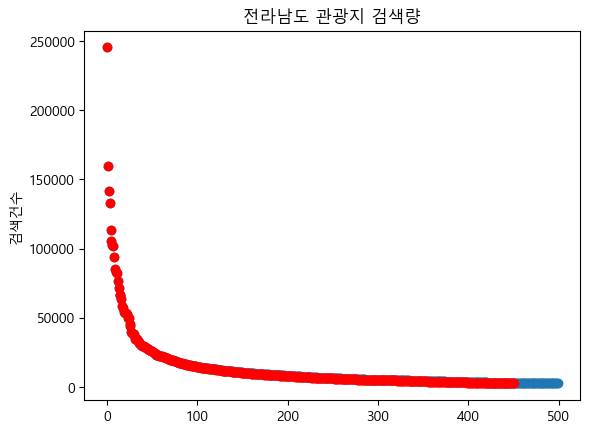

In [44]:
x1=np.arange(len(contents2))
plt.scatter(x1,contents2['검색건수'])
x2=np.arange(len(rnum))
plt.scatter(x2,rnum,c='r')

plt.ylabel('검색건수')
plt.title('전라남도 관광지 검색량') #가는 곳(만) 또 감

In [45]:
ct2=contents2.drop_duplicates(subset=['시/군/구'])
contents_df=ct2.drop(['중분류 카테고리','순위','관광지명','도로명주소'], axis=1).reset_index(drop=True)
print(contents_df)

   시/군/구     소분류 카테고리    검색건수
0    순천시         기타관광  245254
1    목포시         교통시설  159899
2    담양군         자연공원  132973
3    여수시  자연경관(하천/해양)  113284
4    광양시          쇼핑몰  102492
5    완도군         교통시설  101505
6    구례군         종교성지   71502
7    나주시         교통시설   66728
8    고흥군  자연경관(하천/해양)   58260
9    무안군          쇼핑몰   57042
10   장성군         종교성지   54430
11   곡성군         기타관광   45263
12   보성군  자연경관(하천/해양)   39860
13   영광군         교통시설   39224
14   진도군  자연경관(하천/해양)   34692
15   해남군         종교성지   27724
16   신안군         교통시설   23194
17   화순군      육상레저스포츠   22783
18   영암군      육상레저스포츠   21308
19   장흥군           시장   20611
20   강진군         교통시설   20606
21   함평군      육상레저스포츠   19333


데이터 취합

In [46]:
visit=[]

for i in range(len(meal)):
    for j in range(len(contents_df)):
        if meal['항목'][i]==contents_df['시/군/구'][j]:
            visit.append(contents_df['검색건수'][j])

print(visit)

[113284, 245254, 159899, 102492, 66728, 57042, 27724, 21308, 58260, 22783, 101505, 132973, 39224, 39860, 54430, 20611, 20606, 71502, 23194, 34692, 45263, 19333]


In [47]:
meal['검색건수']=visit

meal_columns=['항목','음식점개수','경도','위도','검색건수']
meal.columns=meal_columns

meal.loc[0,'음식점개수']=3875
meal.loc[1,'음식점개수']=3157
meal.loc[2,'음식점개수']=2977
meal.loc[3,'음식점개수']=1974
meal.loc[4,'음식점개수']=1343
meal.loc[5,'음식점개수']=1016

print(meal)

     항목 음식점개수          경도         위도    검색건수
0   여수시  3875  127.662222  34.760374  113284
1   순천시  3157  127.483333  34.950000  245254
2   목포시  2977  126.350000  34.766667  159899
3   광양시  1974  127.695501  34.940548  102492
4   나주시  1343  126.716667  35.033333   66728
5   무안군  1016  126.481686  34.990454   57042
6   해남군   798  126.598927  34.573252   27724
7   영암군   696  126.696792  34.800169   21308
8   고흥군   689  127.284978  34.611222   58260
9   화순군   654  126.986480  35.064503   22783
10  완도군   610  126.755054  34.311060  101505
11  담양군   586  126.988167  35.321139  132973
12  영광군   582  126.511987  35.277172   39224
13  보성군   494  127.079894  34.771456   39860
14  장성군   476  126.784854  35.301833   54430
15  장흥군   444  126.906928  34.681686   20611
16  강진군   434  126.767261  34.642077   20606
17  구례군   419  127.462653  35.202495   71502
18  신안군   385  126.101074  34.827332   23194
19  진도군   376  126.243148  34.460868   34692
20  곡성군   314  127.291918  35.281955   45263
21  함평군   

In [48]:
sites_num=pd.DataFrame([76,41,40,26,25,19,25,12,16,23,18,
                        23,21,16,18,13,17,18,14,16,11,12])
tour_df=pd.concat([meal,sites_num],axis=1,ignore_index=True)
tour_col=['지역','음식점개수','경도','위도','검색건수','관광지개수']
tour_df.columns=tour_col
tour_df.set_index('지역',inplace=True)
tour_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 여수시 to 함평군
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   음식점개수   22 non-null     object 
 1   경도      22 non-null     float64
 2   위도      22 non-null     float64
 3   검색건수    22 non-null     int64  
 4   관광지개수   22 non-null     int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 1.0+ KB


In [49]:
a_index=attract_df.index
t_index=tour_df.index

calmness=[]
accommodation=[]
cafeteria=[]
entranger=[]
aborigene=[]

for i in range(len(tour_df)):
    for j in range(len(attract_df)):
        if t_index[i]==a_index[j]:
            calmness.append(attract_df['비대면지수'][j])
            accommodation.append(attract_df['숙소개수'][j])
            cafeteria.append(attract_df['카페개수'][j])
            aborigene.append(attract_df['평균현지인방문자수'][j])
            entranger.append(attract_df['평균외지인방문자수'][j])
        else:
            continue


tour_df['비대면지수']=calmness
tour_df['숙소개수']=accommodation
tour_df['카페개수']=cafeteria
tour_df['평균외지인방문자수']=entranger
tour_df['평균현지인방문자수']=aborigene

tour_df['음식점개수']=tour_df['음식점개수'].astype('int64')

print(tour_df)

     음식점개수          경도         위도    검색건수  관광지개수       비대면지수  숙소개수  카페개수  \
지역                                                                         
여수시   3875  127.662222  34.760374  113284     76   49.405687   143  1179   
순천시   3157  127.483333  34.950000  245254     41   43.061186    70   860   
목포시   2977  126.350000  34.766667  159899     40   41.232053   268  1226   
광양시   1974  127.695501  34.940548  102492     26   49.087961    44   416   
나주시   1343  126.716667  35.033333   66728     25   62.008706    52   563   
무안군   1016  126.481686  34.990454   57042     19   79.961388    17   121   
해남군    798  126.598927  34.573252   27724     25   73.605863    25   139   
영암군    696  126.696792  34.800169   21308     12   80.345210    20   136   
고흥군    689  127.284978  34.611222   58260     16   69.595750    28   260   
화순군    654  126.986480  35.064503   22783     23   84.238047    27   167   
완도군    610  126.755054  34.311060  101505     18   52.339439    11    85   
담양군    586  

In [50]:
#실제 평가된 지역의 워케이션 점수 추가
prof_score=[5,4,3,0,0,0,0,0,2,0,0,0,0,2,0,0,0,0,2,0,0,0]
tour_df['실제점수']=prof_score

In [55]:
print(tour_df.columns)

Index(['음식점개수', '경도', '위도', '검색건수', '관광지개수', '비대면지수', '숙소개수', '카페개수',
       '평균외지인방문자수', '평균현지인방문자수', '실제점수'],
      dtype='object')


In [61]:
scaler=StandardScaler()

In [105]:
x_df=tour_df.loc[:,['음식점개수','검색건수','관광지개수','숙소개수','카페개수',
               '평균외지인방문자수','평균현지인방문자수','비대면지수']]

x_df=pd.DataFrame(scaler.fit_transform(x_df),
                  columns=['음식점','검색건수','관광지','숙소',
                           '카페','외지인방문','현지인방문','비대면지수'])
print(x_df)

Y=tour_df['실제점수']

         음식점      검색건수       관광지        숙소        카페     외지인방문     현지인방문  \
0   2.850863  0.836628  3.818339  1.755801  2.580347  2.305467  2.122529   
1   2.132107  3.231442  1.309703  0.461714  1.623724  2.143666  2.438057   
2   1.951917  1.682534  1.238028  3.971704  2.721291  2.056133  2.508266   
3   0.947861  0.640789  0.234574  0.000806  0.292248  0.337634  0.574573   
4   0.316196 -0.008208  0.162898  0.142624  0.733075  0.735659  0.494111   
5  -0.011148 -0.183977 -0.267153 -0.477829 -0.592403  0.529854  0.054220   
6  -0.229378 -0.716000  0.162898 -0.336011 -0.538424 -0.365565 -0.329220   
7  -0.331485 -0.832429 -0.768881 -0.424648 -0.547421 -0.132681 -0.273492   
8  -0.338493 -0.161874 -0.482179 -0.282830 -0.175567 -0.661590 -0.456008   
9  -0.373529 -0.805663  0.019548 -0.300557 -0.454457  0.175230 -0.164840   
10 -0.417576  0.622878 -0.338829 -0.584193 -0.700360 -0.792226 -0.368792   
11 -0.441601  1.193917  0.019548 -0.016921  0.142308  0.620288 -0.473447   
12 -0.445605

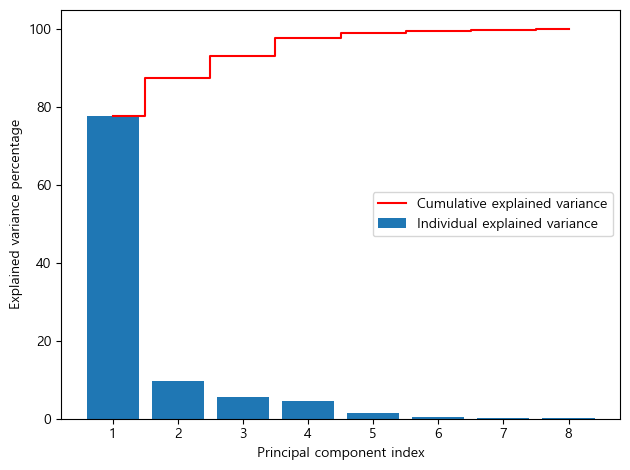

In [129]:
pca = PCA(n_components=None)
pca.fit(x_df)

# Plot cumulative explained variances
exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

plt.bar(range(1,9), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(1,9), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(1,9)))
plt.legend(loc=5)
plt.tight_layout()

In [108]:
pca=PCA(n_components=3)
x_pca=pca.fit_transform(x_df)

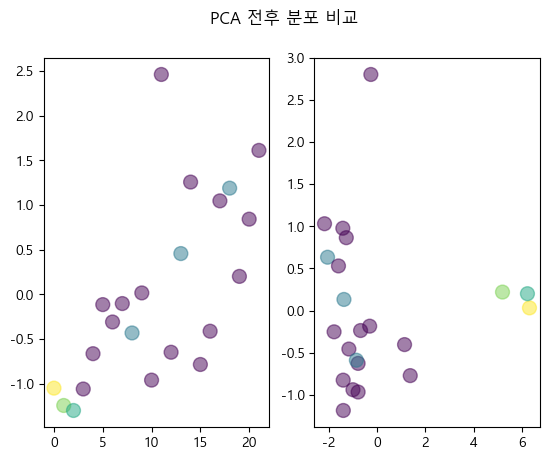

In [158]:
fig, axs = plt.subplots(1,2)

axs[0].scatter(np.arange(len(x_df)), x_df['비대면지수'], 
                s=100, c=Y, cmap='viridis', alpha=0.5)

axs[1].scatter(x_pca[:,0], x_pca[:,1], 
                s=100, c=Y, cmap='viridis', alpha=0.5)

fig.suptitle('PCA 전후 분포 비교')
plt.show()

In [164]:
lr=LinearRegression()
lr.fit(x_pca,Y)
print(lr.intercept_,lr.coef_)
#y=0.45495386X1+0.11684108X2+(-0.09761687)X3+0.8181818181818182

0.8181818181818182 [ 0.45495386  0.11684108 -0.09761687]


시각화

In [ ]:
xmin=min(coord_std['경도'])
xmax=max(coord_std['경도'])
ymin=min(coord_std['위도'])
ymax=max(coord_std['위도'])

In [ ]:
coord_std.dropna(axis=0)
dong=pd.DataFrame(coord_std['시군구'].value_counts())

d_index=dong.index
d_num=[]

for i in range(len(tour_df)):
    for j in range(len(dong)):
        if t_index[i]==d_index[j]:
            d_num.append(dong['count'][j])

In [ ]:
#숙소유형
plt.scatter(x=accomm_df['경도'],y=accomm_df['위도'],alpha=0.1,label='숙소')

plt.scatter(x=cafe['경도'],y=cafe['위도'],alpha=0.1,label='카페')

tour_df.plot(kind='scatter',x='경도', y='위도',
             s=tour_df['평균현지인방문자수']/100000,label='평균 현지인 방문 수',
             c=tour_df['음식점개수'],cmap='jet',colorbar=True)

#plt.title('숙소 및 카페 분포도')

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.legend()

plt.show() 

#새로운 지표 개발. 선형 결합
#워케이션 인디케이터: -> 성능 향상도: 유력 지역이 많이 나오도록 세부 조정하면서 지표 개발
#--> 과학적 기법을 썼다는 거만 명시: 예) gridSearch
#hidden jam 찾기
#기존 지표와 나란히 놓고 side to side 비교
#map 위에 바로 플로팅

#교통과 워케이션 지수도 디자인 영역: "우리가 새로 한 거"

#장당 10초 발표 하는데 막히면 누구도 이해 못함<--매우 중요
#색 다 털어서 3색
#2030: 5060세대 비해 적/많은 만큼 가중치 다르게

#2030은 자차보유율이 떨어진다. 그래서 더 교통 인프라가 더 중요하다.
#work 가 포함되는 부분은 교통 인프라

#이거 합친 게 지표다.

#정렬하면: 지표로 나열하겠다. 분석과 이어지게(통합안)

#지금 기업이 선택한 전남 워케이션 지역은 어디지?

#파이랑 프린트아웃 보조
#프린트아웃: 2장 모아찍기 출력해와야 visualbility 확보
#12일까지 초안

In [ ]:
coord_std.dropna(axis=0,inplace=True)
print(coord_std)

In [ ]:
avg_meal_num=dict(tour_df['평균 식당 개수'])
avg_meal_num